In [42]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go

except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import scipy.cluster.hierarchy as sch
from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator
#------------------------------------------------------------------
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer

Data Collection and Cleaning

In [44]:
df = pd.read_csv("bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [46]:
#delete missing data and check for duplicates
df.dropna(inplace = True)
df.duplicated().sum()

np.int64(0)

TransactionDate and CustomerDOB are both in string datatype and I will be converting them to datetime

In [47]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

C:\Users\gdmarques\AppData\Local\Temp\ipykernel_2220\3105320130.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
C:\Users\gdmarques\AppData\Local\Temp\ipykernel_2220\3105320130.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])


I will calculate the customer age, by subtracting the TransactionData with the CustomerDOB and will delete TransactionTime since I don't know it can be usefull

In [48]:
df['CustomerAge'] = df['TransactionDate'].dt.year-df['CustomerDOB'].dt.year

In [49]:
df.drop(columns = ['TransactionTime'], inplace = True)

In [50]:
df.drop(df[df['CustGender']=='T'].index,inplace=True)

In [51]:
num_col = df.select_dtypes(include = np.number)
cat_col = df.select_dtypes(include = np.number)

In [52]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,25.0,22
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,27999.0,-41
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,459.0,20
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2016-02-08,2060.0,-57
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1762.5,28


Now that the data is cleaned, i will performe RFM on it.

RFM is a marketing technique that allows you to segment your audience according to theier relevance to your business.

RFM stands for: 
    -Recency: number of days since the last purchase or order
    -Frequency: average orders during a certain period(for instance, number of monthly purchases)
    -Monetary Value: total order amount during a specific time frame.



Lets start with Recency, in this use case, it is the number of days since the last purchase or order.
To calculate this I will create a new column to subtract the last transaction from the first transaction

In [68]:
df['TransactionDate1'] = df['TransactionDate'] #first transaction
df['TransactionDate2'] = df['TransactionDate'] #last transaction

In [69]:
MRF_df = df.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "CustomerAge" : "median",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

MRF_df = MRF_df.reset_index()
MRF_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [70]:
MRF_df.shape

(879357, 10)

In [71]:
MRF_df.drop(columns=["CustomerID"],inplace=True)

In [72]:
MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [73]:
MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']


In [74]:
MRF_df['Recency']=MRF_df['Recency'].astype(str)

In [75]:
x='18 day'
re.search('\d+',x).group()

'18'

In [76]:
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)

In [77]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
MRF_df['Recency']=MRF_df['Recency'].apply(rep_0)

Since the recency is already calculated, the columns created before, are now useless for me, so I will drop them

In [78]:
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

Now I will detect and summarize the outliers information in a new DataFrame

In [79]:
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=MRF_df[(MRF_df[i] < lower) | (MRF_df[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))

    
dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

,lower,upper,outliers,Perc%
Frequency,1.000,1.000,141961,16.14
CustAccountBalance,-78334.780,145468.020,116569,13.26
TransactionAmount (INR),-1384.325,2816.195,91776,10.44
CustomerAge,10.500,46.500,139949,15.91
Recency,1.000,1.000,136120,15.48


In [80]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1


DATA ANALYSIS

In [81]:
MRF_df.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
count,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357,879357.000000
mean,1.184517,1.147151e+05,1.566759e+03,31.928997,2016-07-26 00:35:32.299851008,15.876154
min,1.000000,0.000000e+00,0.000000e+00,-57.000000,2016-01-08 00:00:00,1.000000
25%,1.000000,5.591270e+03,1.908700e+02,24.000000,2016-06-09 00:00:00,1.000000
50%,1.000000,1.866578e+04,5.000000e+02,28.000000,2016-08-19 00:00:00,1.000000
75%,1.000000,6.154197e+04,1.241000e+03,33.000000,2016-09-09 00:00:00,1.000000
max,6.000000,1.150355e+08,1.560035e+06,216.000000,2016-12-09 00:00:00,336.000000
std,0.448954,8.010842e+05,6.433167e+03,47.339366,NaN,46.653921


Correlation between features

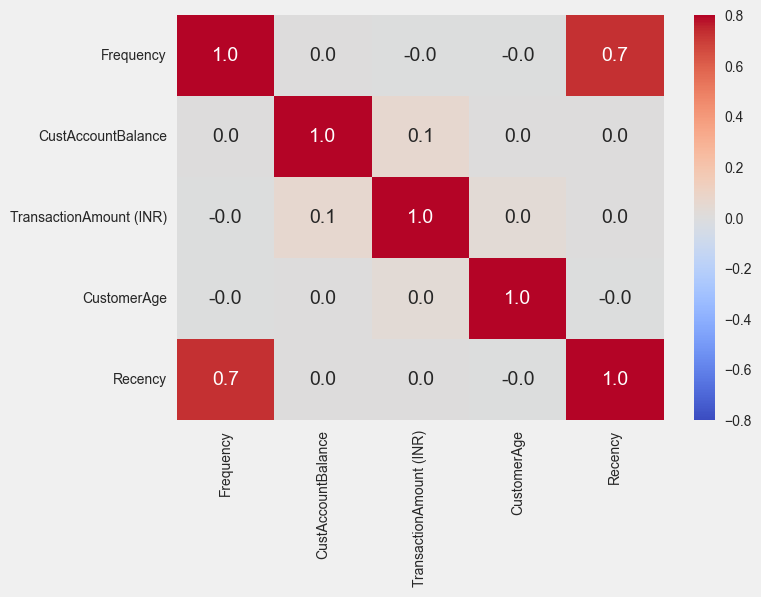

In [85]:
numeric_cols = MRF_df.select_dtypes(include=[np.number])

plt.figure(figsize=(7,5))
correlation = numeric_cols.corr()  # Perform correlation only on numeric columns

sns.heatmap(correlation, vmin=-0.8, vmax=0.8, cmap='coolwarm', annot=True, fmt='.1f', 
            linecolor='white', cbar=True)

plt.show()


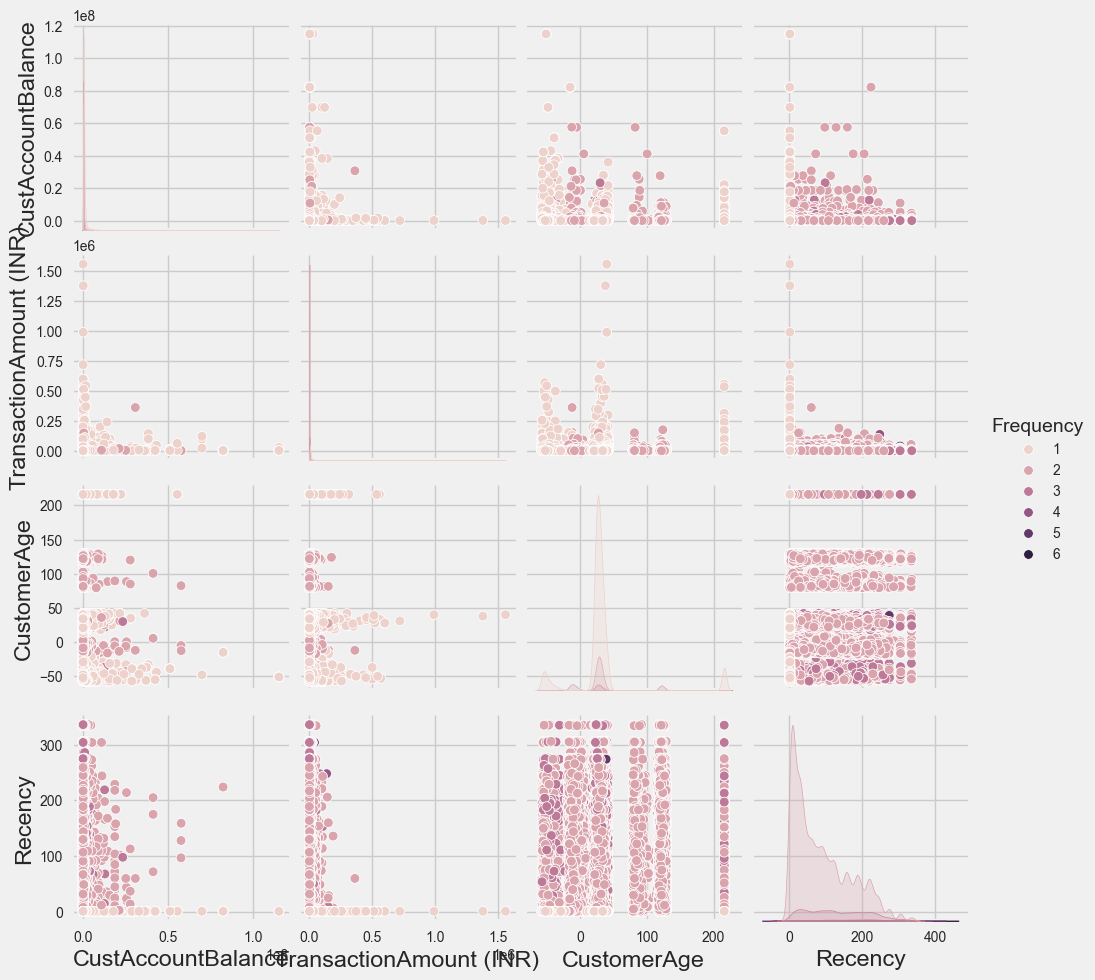

In [86]:
plt.style.use("fivethirtyeight")
sns.pairplot(MRF_df,hue="Frequency")

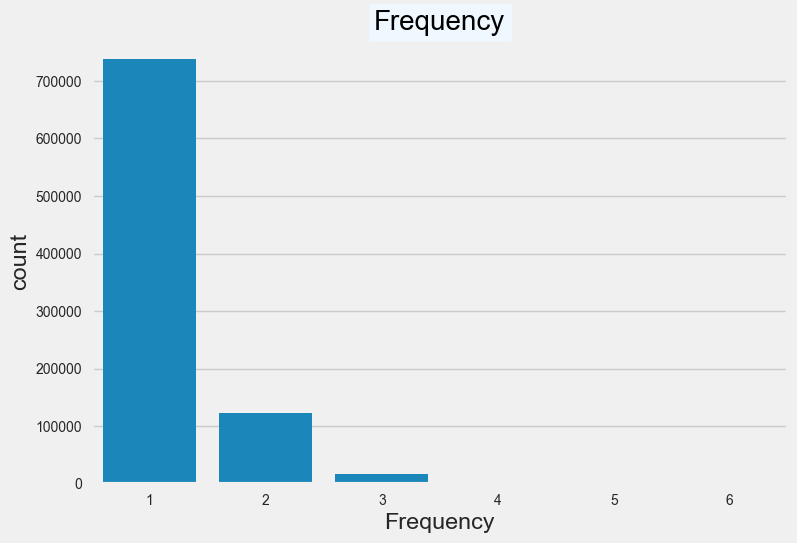

In [92]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='Frequency',data=MRF_df, order = MRF_df['Frequency'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='black');

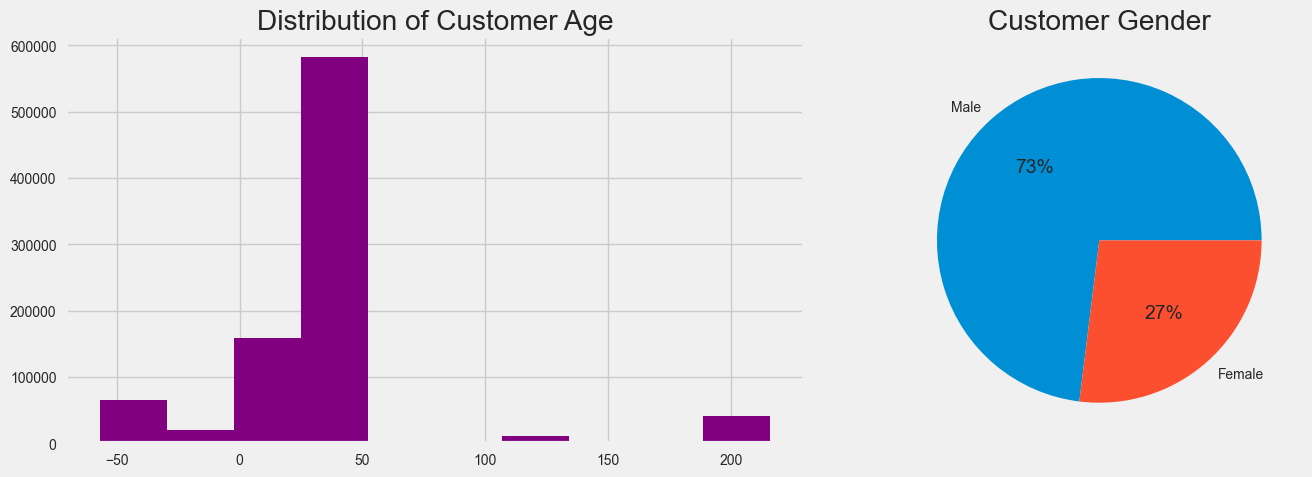

In [93]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette()
ax[0].hist(x=MRF_df['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(MRF_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

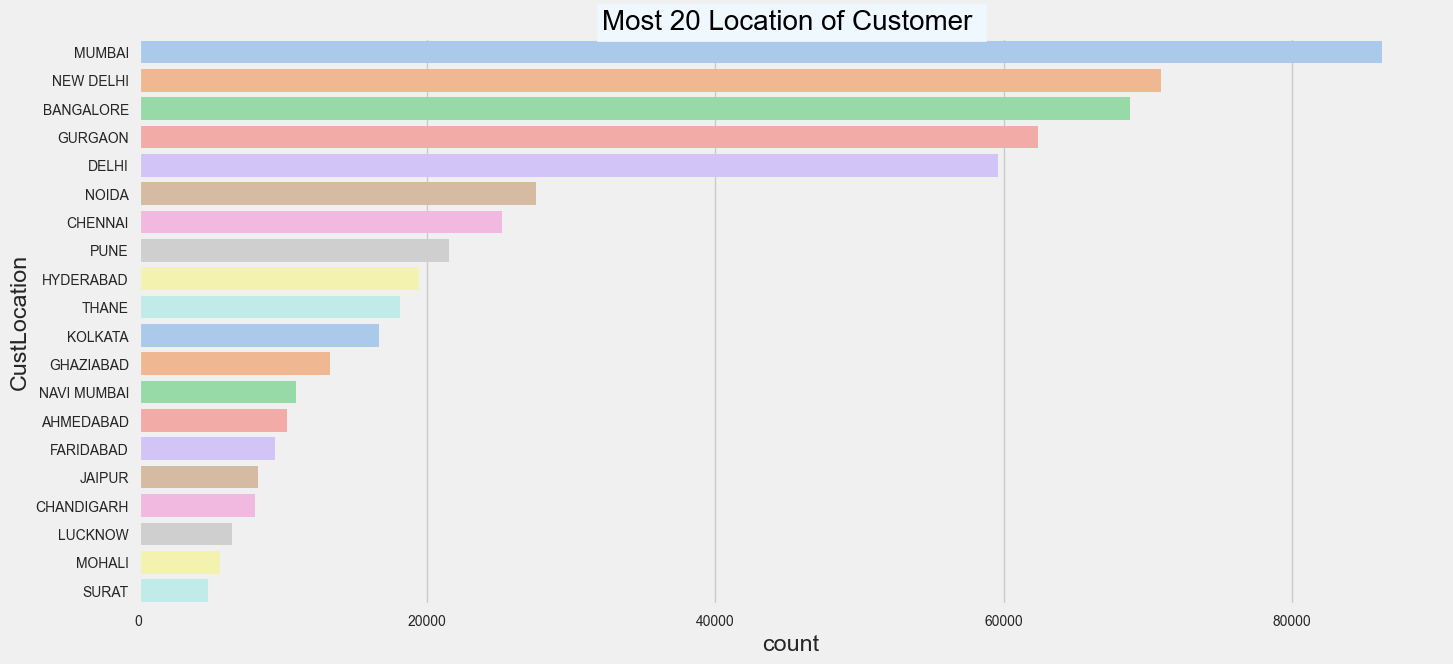

In [95]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=MRF_df,palette='pastel', order = MRF_df['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='black');

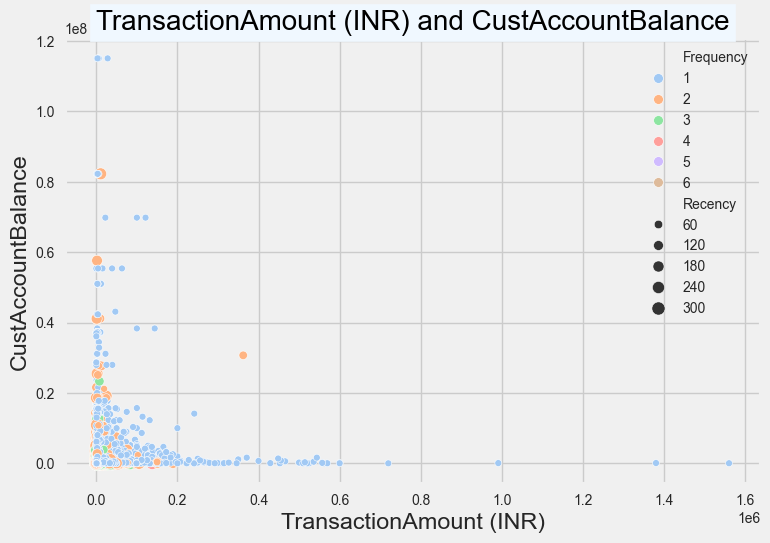

In [96]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=MRF_df,palette='pastel',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='Black');

In [98]:
MRF_df['TransactionDate'].max()-MRF_df['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [102]:
MRF_df=MRF_df.sort_values(by='TransactionDate')
groupbby_month = MRF_df.groupby(pd.Grouper(key='TransactionDate', freq='M')).mean(numeric_only=True)
print(groupbby_month.shape)
groupbby_month

(12, 5)


,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
TransactionDate,,,,,
2016-01-31,1.025196,107508.805797,1448.714678,32.260653,1.918747
2016-02-29,1.064317,105680.497569,1502.272034,32.496170,5.091711
2016-03-31,1.091612,111479.999592,1643.042085,31.595601,8.617264
2016-04-30,1.172430,114318.492265,1691.246723,30.694105,25.188155
2016-05-31,1.355424,109561.572298,1592.128640,31.624119,62.542281
2016-06-30,1.359702,109571.765181,1658.123285,31.364042,53.389229
2016-07-31,1.354797,106349.124901,1573.295768,30.918318,37.011021
2016-08-31,1.158752,120503.189601,1569.334883,32.177685,7.485432
2016-09-30,1.211712,117934.764734,1530.263571,32.545225,10.531790


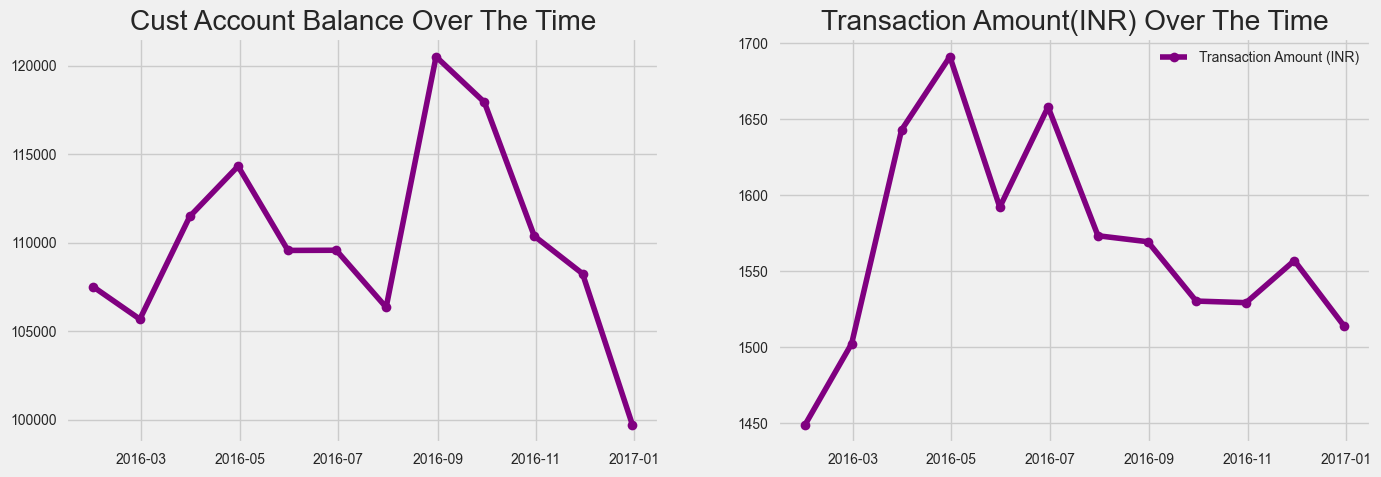

In [103]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend();

FEATURE ENGINEERING